# 0 - IMPORTS

In [102]:
import re
import numpy        as np
import pandas       as pd
import seaborn      as sns
import umap.umap_   as umap

from matplotlib     import pyplot       as plt
from plotly         import express      as px

from sklearn        import cluster              as c
from sklearn        import metrics              as me
from sklearn        import preprocessing        as pp

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 - Helper functions

## 0.2 - Load dataset

In [58]:
# load data
df_raw = pd.read_csv('dataset/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1 - Descrição dos dados

In [59]:
df1 = df_raw.copy()

## 1.1 - Rename columns

In [60]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 - Data dimensions

In [61]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [62]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 - Check NA

In [63]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 - Replace NA

In [64]:
df1.dropna(subset=['description', 'customer_id'], inplace=True)
print('Removed data: {:.2f}%'.format(100*(1-df1.shape[0]/df_raw.shape[0])))

Removed data: 24.93%


In [65]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 - Change Dtypes

In [66]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [67]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive statistics

In [68]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numerical Attributes

In [69]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.7.2 - Categorical Attributes

#### invoice_no

In [70]:
# invoice_no: Há letras e números nas strings, não se transforma em int
n_diff = len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())
perc = n_diff/cat_attributes['invoice_no'].drop_duplicates().shape[0]
print('Qtde de valores com letras: {}  |  Representatividade: {}'.format(n_diff, str(np.round(perc*100,2))+'%'))

Qtde de valores com letras: 3654  |  Representatividade: 16.47%


#### stock_code

In [71]:
# stock code
n_diff = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())
perc = n_diff/cat_attributes['stock_code'].drop_duplicates().shape[0]
print('Qtde de valores com letras: {}  |  Representatividade: {}'.format(n_diff, str(np.round(perc*100,2))+'%'))

Qtde de valores com letras: 886  |  Representatividade: 24.05%


In [72]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# 2 - Filtragem de variáveis

In [73]:
df2 = df1.copy()

In [74]:
# Numerical Attributes
# unit_price >0.0
df2 = df2.loc[df2['unit_price']>0.010, :]

# stock_code != [POST, D, M, DOT, CRUK, C2]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]

# description
df2 = df2.drop('description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity - negative numbers means product returns
df2_returns = df2.loc[df2['quantity']<0,:]
df2_purchase = df2.loc[df2['quantity']>0,:]

# 3 - Feature engineering

In [75]:
df3 = df2.copy()

In [76]:
# data reference
df_ref = df3[['customer_id']].copy()
df_ref = df_ref.drop_duplicates(ignore_index=True)

In [77]:
# gross_revenue (Faturamento = quantity * unit_price)
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity']*df2_purchase.loc[:, 'unit_price']

/tmp/ipykernel_5921/2000140949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity']*df2_purchase.loc[:, 'unit_price']


In [78]:
# monetary
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

In [79]:
# recency - last day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [80]:
# frequency
df_freq = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [81]:
# Avg Ticket
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

# 4 - Análise exploratória de dados (EDA)

In [82]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# 5 - Data preparation

In [103]:
df5 = df4.copy()

In [104]:
# MinMax Scaler
mms = pp.MinMaxScaler()

df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = mms.fit_transform(df5[['recency_days']])
df5['invoice_no'] = mms.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']])

# 6 - Feature selection

In [105]:
df6 = df5.copy()

# 7 - Hyperparameter fine-tuning

In [106]:
X = df6.drop('customer_id', axis=1)

In [107]:
clusters = [2, 3, 4, 5, 6, 7]

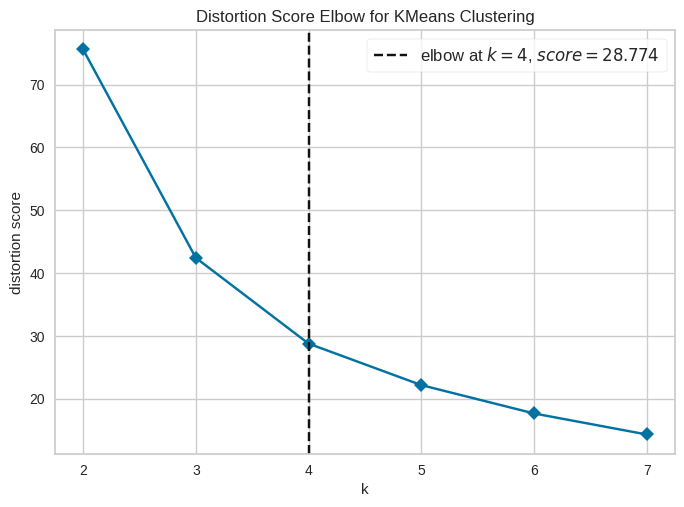

In [108]:
# WSS
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

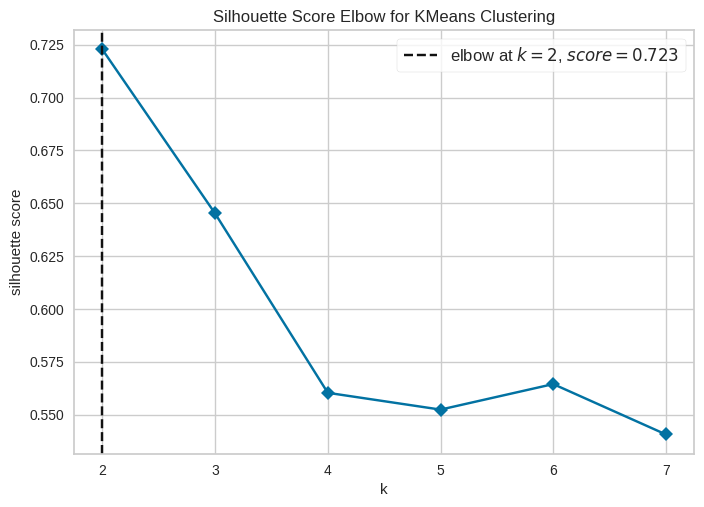

In [109]:
# Silhouette
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

## 7.1 - Silhouette Analysis



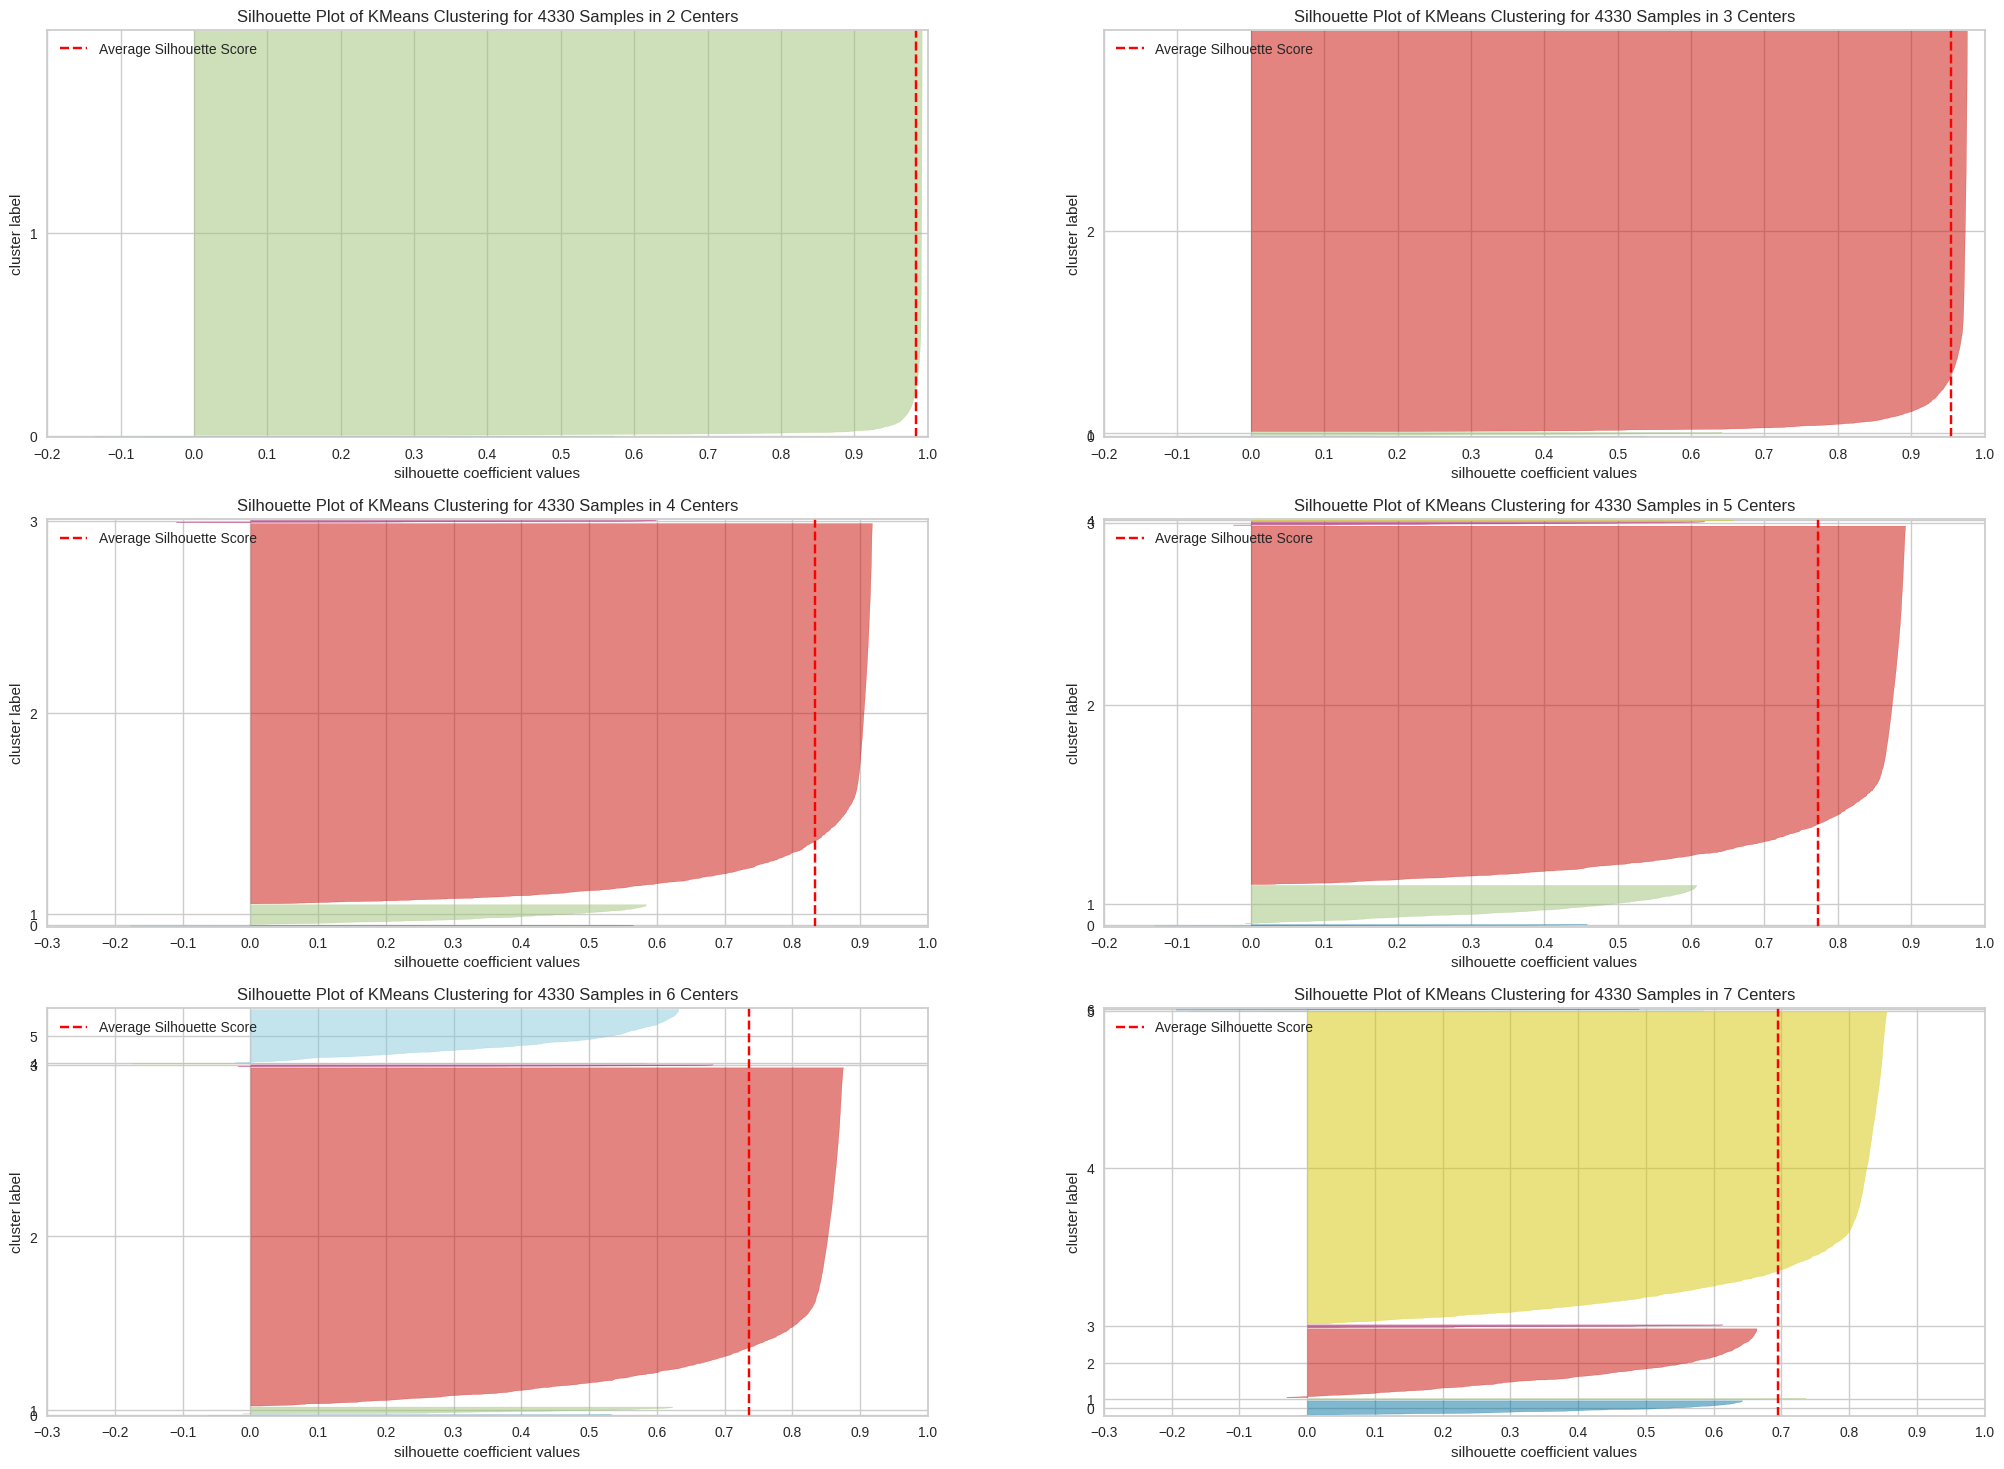

In [88]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))
for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8 - Model training

## 8.1 - K-Means

In [92]:
# mode definition
k = 5
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 - Cluster validation

In [94]:
# WSS
print('WSS value: {}'.format(kmeans.inertia_))

# Silhouette Score
print('SS value: {}'.format(me.silhouette_score(X, labels, metric='euclidean')))

WSS value: 35879671974.89336
SS value: 0.7731573427789148


# 9 - Cluster Analysis

In [95]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 - Visualization Inspection

/home/fausto/repos/clustering/cluster/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


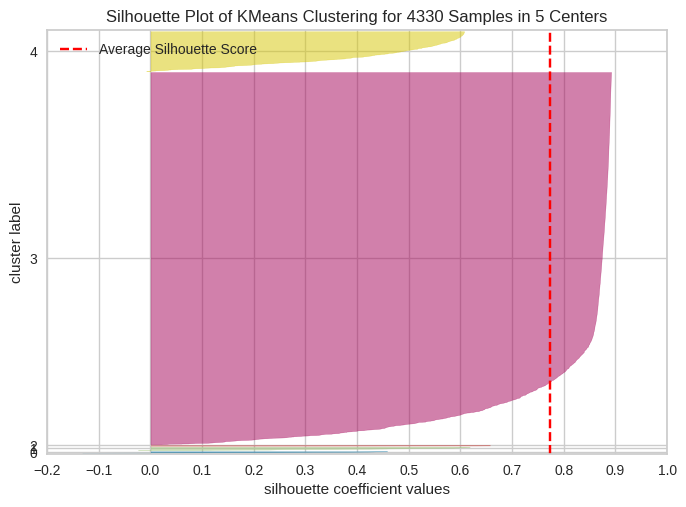

In [96]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d plot

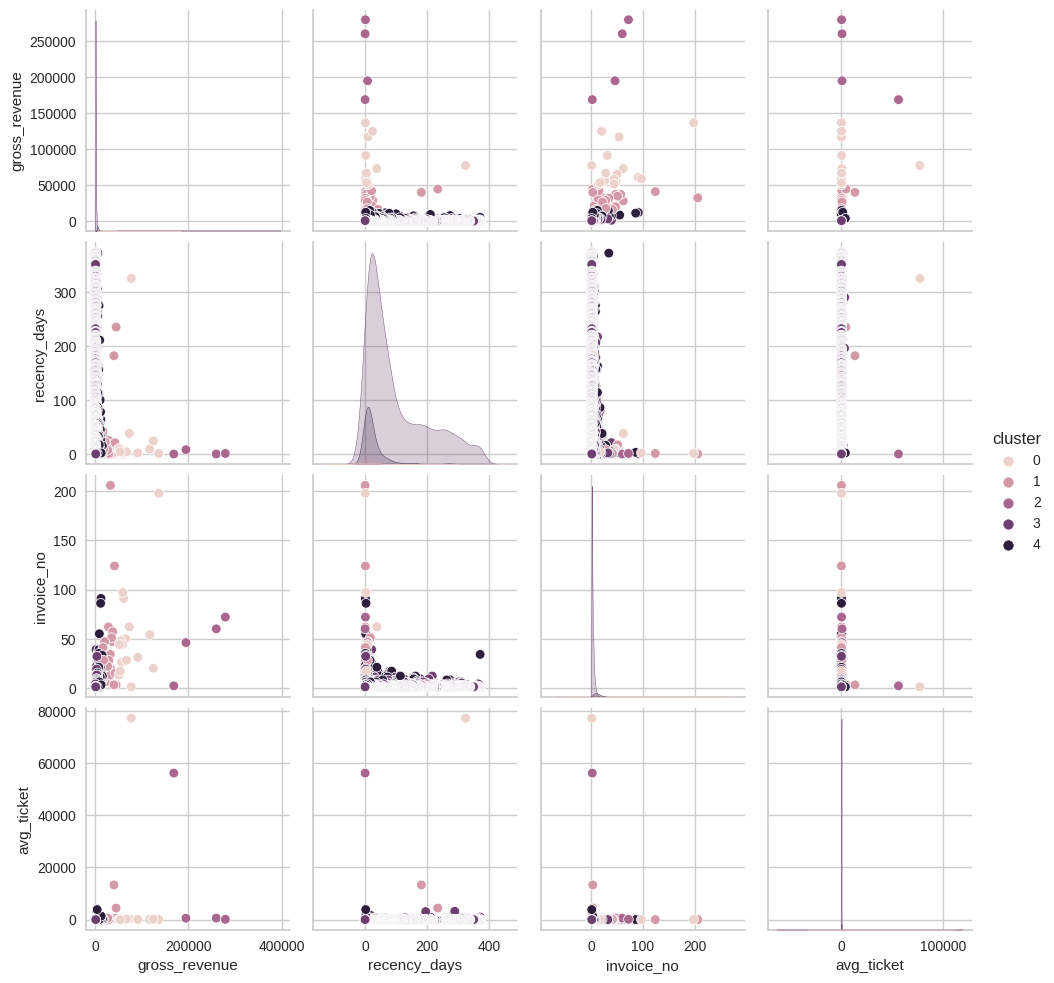

In [97]:
df_viz = df9.drop('customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3 UMAP

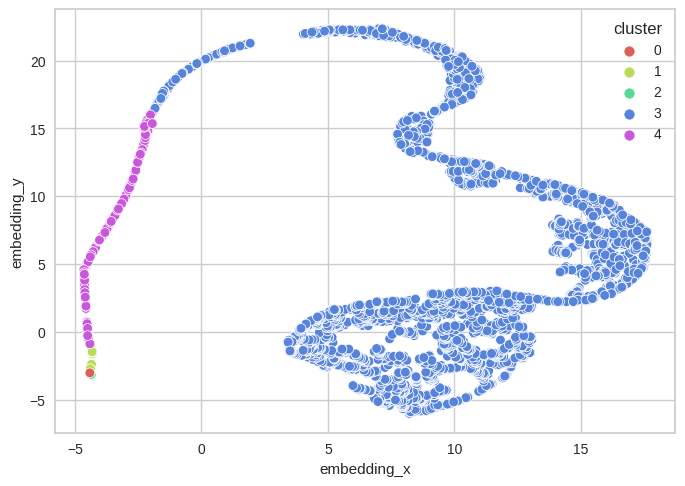

In [101]:
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

In [99]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
#fig.show()

## 9.4 - Cluster Profile

In [100]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = np.round(100*df_cluster['customer_id']/df_cluster['customer_id'].sum(), 2).astype(str)+'%'
df_cluster

# Avg gross_revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_gross_revenue['gross_revenue'] = '$' + np.round(df_avg_gross_revenue['gross_revenue'], 2).astype(str)
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency_days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_recency_days['recency_days'] = np.round(df_avg_recency_days['recency_days'], 2).astype(str) + ' dias'
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_invoice_no['invoice_no'] = np.round(df_avg_invoice_no['invoice_no'], 2).astype(str) + ' produtos'
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,16,0.37%,$74629.98,27.56 dias,51.5 produtos,4988.347953
1,1,38,0.88%,$25173.13,17.79 dias,34.16 produtos,585.432464
2,2,4,0.09%,$225454.65,2.25 dias,45.0 produtos,14368.189768
3,3,3859,89.12%,$843.5,100.34 dias,2.85 produtos,28.482479
4,4,413,9.54%,$5931.88,26.19 dias,12.38 produtos,60.566959
